# LLM Game Theory Performance Analysis

Which types of games does the LLM excel at, and which does it struggle with?

This notebook analyzes the `run_20260219_172049` dataset to identify patterns in LLM performance across different game structures.

In [1]:
import pandas as pd
import numpy as np
import json
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Load the dataset
data_dir = Path("../results/run_20260219_172049")

with open(data_dir / "games.json") as f:
    games = json.load(f)

with open(data_dir / "trials.json") as f:
    trials = json.load(f)

with open(data_dir / "summary.json") as f:
    summary = json.load(f)

print(f"✓ Loaded {len(games)} games")
print(f"✓ Loaded {len(trials)} trials")
print(f"\nDataset Summary:")
for key, val in summary.items():
    if isinstance(val, float):
        print(f"  {key}: {val:.4f}")
    else:
        print(f"  {key}: {val}")

/Users/andy/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/andy/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


✓ Loaded 100 games
✓ Loaded 100 trials

Dataset Summary:
  num_games: 100
  num_trials_per_game: 1
  total_trials: 100
  mean_nash_gap: 17.5913
  median_nash_gap: 0.0000
  std_nash_gap: 30.5825
  min_nash_gap: 0.0000
  max_nash_gap: 141.7442
  mean_llm_value: -21.4762
  mean_br_value: -3.8849


## Section 1: Analyze Game Properties & Performance

What characteristics make a game hard or easy for the LLM?

In [3]:
# Compute game properties
def analyze_game_properties(game):
    """Extract features from a game matrix."""
    matrix = np.array(game['payoff_matrix'])
    nash_row = np.array(game['nash_equilibrium_row'])
    nash_col = np.array(game['nash_equilibrium_col'])
    
    # Check if Nash equilibrium is pure strategy
    is_pure_row = np.sum(nash_row == 1.0) == 1
    is_pure_col = np.sum(nash_col == 1.0) == 1
    is_pure_nash = is_pure_row and is_pure_col
    
    # Payoff statistics
    flat = matrix.flatten()
    payoff_mean = np.mean(flat)
    payoff_std = np.std(flat)
    payoff_range = np.max(flat) - np.min(flat)
    
    # Check for dominant strategies
    # Row player: dominant row is better against all column strategies
    has_dominant_row = False
    has_dominant_col = False
    
    for i in range(len(matrix)):
        if all(matrix[i, j] >= matrix[k, j] for j in range(len(matrix[0])) for k in range(len(matrix))):
            has_dominant_row = True
            break
    
    for j in range(len(matrix[0])):
        if all(matrix[i, j] >= matrix[i, k] for i in range(len(matrix)) for k in range(len(matrix[0]))):
            has_dominant_col = True
            break
    
    # Zero-sum property (already guaranteed, but measure how balanced)
    row_payoffs = [matrix[i, :].sum() for i in range(len(matrix))]
    col_payoffs = [matrix[:, j].sum() for j in range(len(matrix[0]))]
    row_payoff_variance = np.var(row_payoffs)
    
    return {
        'game_id': game['game_id'],
        'is_pure_nash': is_pure_nash,
        'has_dominant_row': has_dominant_row,
        'has_dominant_col': has_dominant_col,
        'payoff_mean': payoff_mean,
        'payoff_std': payoff_std,
        'payoff_range': payoff_range,
        'row_payoff_variance': row_payoff_variance,
    }

# Analyze all games
game_properties = pd.DataFrame([analyze_game_properties(g) for g in games])

# Create trials dataframe
trials_df = pd.DataFrame(trials)

# Merge game properties with trial results
merged_df = trials_df.merge(game_properties, on='game_id')

print("Game Properties Summary:")
print(game_properties.describe().round(2))
print(f"\nPure Nash Equilibria: {game_properties['is_pure_nash'].sum()}/{len(game_properties)}")
print(f"Games with dominant row strategy: {game_properties['has_dominant_row'].sum()}/{len(game_properties)}")
print(f"Games with dominant col strategy: {game_properties['has_dominant_col'].sum()}/{len(game_properties)}")

Game Properties Summary:
       game_id  payoff_mean  payoff_std  payoff_range  row_payoff_variance
count   100.00       100.00      100.00        100.00               100.00
mean     49.50        -1.61       52.38        158.89              5723.08
std      29.01        19.25        8.70         23.50              5203.59
min       0.00       -36.09       31.13         95.06                64.87
25%      24.75       -16.61       45.67        142.45              2032.96
50%      49.50        -0.03       53.51        165.82              4118.63
75%      74.25        13.81       58.12        177.94              7645.80
max      99.00        42.89       71.44        194.04             26102.58

Pure Nash Equilibria: 0/100
Games with dominant row strategy: 6/100
Games with dominant col strategy: 14/100


## Section 2: Classification - Easy vs Hard Games

Categorize games by Nash gap (0 = optimal play, large = suboptimal).

In [4]:
# Create categories based on Nash gap
merged_df['performance_category'] = pd.cut(
    merged_df['nash_gap'], 
    bins=[-0.01, 0.01, 10, 50, float('inf')],
    labels=['Optimal (gap≈0)', 'Good (gap<10)', 'Medium (gap<50)', 'Poor (gap≥50)']
)

# Statistics by performance category
print("LLM Performance Distribution:")
perf_counts = merged_df['performance_category'].value_counts().sort_index()
for cat, count in perf_counts.items():
    pct = 100 * count / len(merged_df)
    print(f"  {cat}: {count} games ({pct:.1f}%)")

# Find specific easy and hard games
optimal_games = merged_df[merged_df['nash_gap'] < 0.01]['game_id'].tolist()
hard_games = merged_df[merged_df['nash_gap'] > 50]['game_id'].tolist()

print(f"\n✓ {len(optimal_games)} games played optimally (Nash gap ≈ 0)")
print(f"✗ {len(hard_games)} games where LLM struggled (Nash gap > 50)")

# Show examples
print("\n--- Example OPTIMAL Games (LLM played Nash-optimal) ---")
for gid in optimal_games[:3]:
    game = games[gid]
    trial = merged_df[merged_df['game_id'] == gid].iloc[0]
    print(f"\nGame {gid}:")
    print(f"  Nash gap: {trial['nash_gap']:.6f}")
    print(f"  Payoff matrix mean: {trial['payoff_mean']:.2f}, std: {trial['payoff_std']:.2f}")
    print(f"  Pure Nash: {trial['is_pure_nash']}")

print("\n--- Example HARD Games (LLM made poor decisions) ---")
for gid in hard_games[:3]:
    game = games[gid]
    trial = merged_df[merged_df['game_id'] == gid].iloc[0]
    print(f"\nGame {gid}:")
    print(f"  Nash gap: {trial['nash_gap']:.2f}")
    print(f"  Payoff matrix mean: {trial['payoff_mean']:.2f}, std: {trial['payoff_std']:.2f}")
    print(f"  Pure Nash: {trial['is_pure_nash']}")
    print(f"  Payoff range: {trial['payoff_range']:.2f}")

LLM Performance Distribution:
  Optimal (gap≈0): 59 games (59.0%)
  Good (gap<10): 9 games (9.0%)
  Medium (gap<50): 16 games (16.0%)
  Poor (gap≥50): 16 games (16.0%)

✓ 59 games played optimally (Nash gap ≈ 0)
✗ 16 games where LLM struggled (Nash gap > 50)

--- Example OPTIMAL Games (LLM played Nash-optimal) ---

Game 0:
  Nash gap: 0.000000
  Payoff matrix mean: -33.66, std: 45.21
  Pure Nash: False

Game 1:
  Nash gap: 0.000000
  Payoff matrix mean: -36.09, std: 52.46
  Pure Nash: False

Game 2:
  Nash gap: 0.000000
  Payoff matrix mean: 7.21, std: 54.00
  Pure Nash: False

--- Example HARD Games (LLM made poor decisions) ---

Game 7:
  Nash gap: 63.43
  Payoff matrix mean: -25.17, std: 40.68
  Pure Nash: False
  Payoff range: 115.71

Game 12:
  Nash gap: 101.19
  Payoff matrix mean: 30.65, std: 46.86
  Pure Nash: False
  Payoff range: 128.85

Game 16:
  Nash gap: 66.73
  Payoff matrix mean: -28.30, std: 49.14
  Pure Nash: False
  Payoff range: 172.78


## Section 3: Correlations - What Game Properties Affect Performance?

In [5]:
# Correlation with Nash gap
correlation_cols = ['payoff_mean', 'payoff_std', 'payoff_range', 'row_payoff_variance']
correlations = merged_df[correlation_cols + ['nash_gap']].corr()['nash_gap'].sort_values(ascending=False)

print("Correlation with Nash Gap (higher = more difficult games):")
print(correlations.round(3))

# Statistical analysis: does Pure vs Mixed Nash matter?
print("\n--- Pure vs Mixed Strategy Nash Equilibrium ---")
pure_nash_subset = merged_df[merged_df['is_pure_nash'] == True]['nash_gap']
mixed_nash_subset = merged_df[merged_df['is_pure_nash'] == False]['nash_gap']

print(f"Pure Nash:  mean gap = {pure_nash_subset.mean():.2f} (n={len(pure_nash_subset)})")
print(f"Mixed Nash: mean gap = {mixed_nash_subset.mean():.2f} (n={len(mixed_nash_subset)})")

# T-test for significance
t_stat, p_value = stats.ttest_ind(pure_nash_subset, mixed_nash_subset)
print(f"T-test: t={t_stat:.3f}, p={p_value:.4f}")
if p_value < 0.05:
    print("✓ Statistically significant difference!")
else:
    print("✗ No significant difference")

# Analysis by dominant strategies
print("\n--- Dominant Strategy Analysis ---")
dominant_row = merged_df[merged_df['has_dominant_row'] == True]['nash_gap'].describe()
no_dominant_row = merged_df[merged_df['has_dominant_row'] == False]['nash_gap'].describe()

print(f"With dominant row: mean={dominant_row['mean']:.2f}")
print(f"No dominant row: mean={no_dominant_row['mean']:.2f}")

# Correlation with payoff variance
corr_payoff_std = merged_df['payoff_std'].corr(merged_df['nash_gap'])
print(f"\nCorrelation (payoff_std, nash_gap): {corr_payoff_std:.3f}")
print(f"Interpretation: {'High payoff variance makes games harder' if corr_payoff_std > 0.3 else 'Payoff variance less important'}")

Correlation with Nash Gap (higher = more difficult games):
nash_gap               1.000
row_payoff_variance    0.312
payoff_mean            0.187
payoff_std            -0.018
payoff_range          -0.023
Name: nash_gap, dtype: float64

--- Pure vs Mixed Strategy Nash Equilibrium ---
Pure Nash:  mean gap = nan (n=0)
Mixed Nash: mean gap = 17.59 (n=100)
T-test: t=nan, p=nan
✗ No significant difference

--- Dominant Strategy Analysis ---
With dominant row: mean=19.31
No dominant row: mean=17.48

Correlation (payoff_std, nash_gap): -0.018
Interpretation: Payoff variance less important


## Section 4: Visualizations - See the Patterns

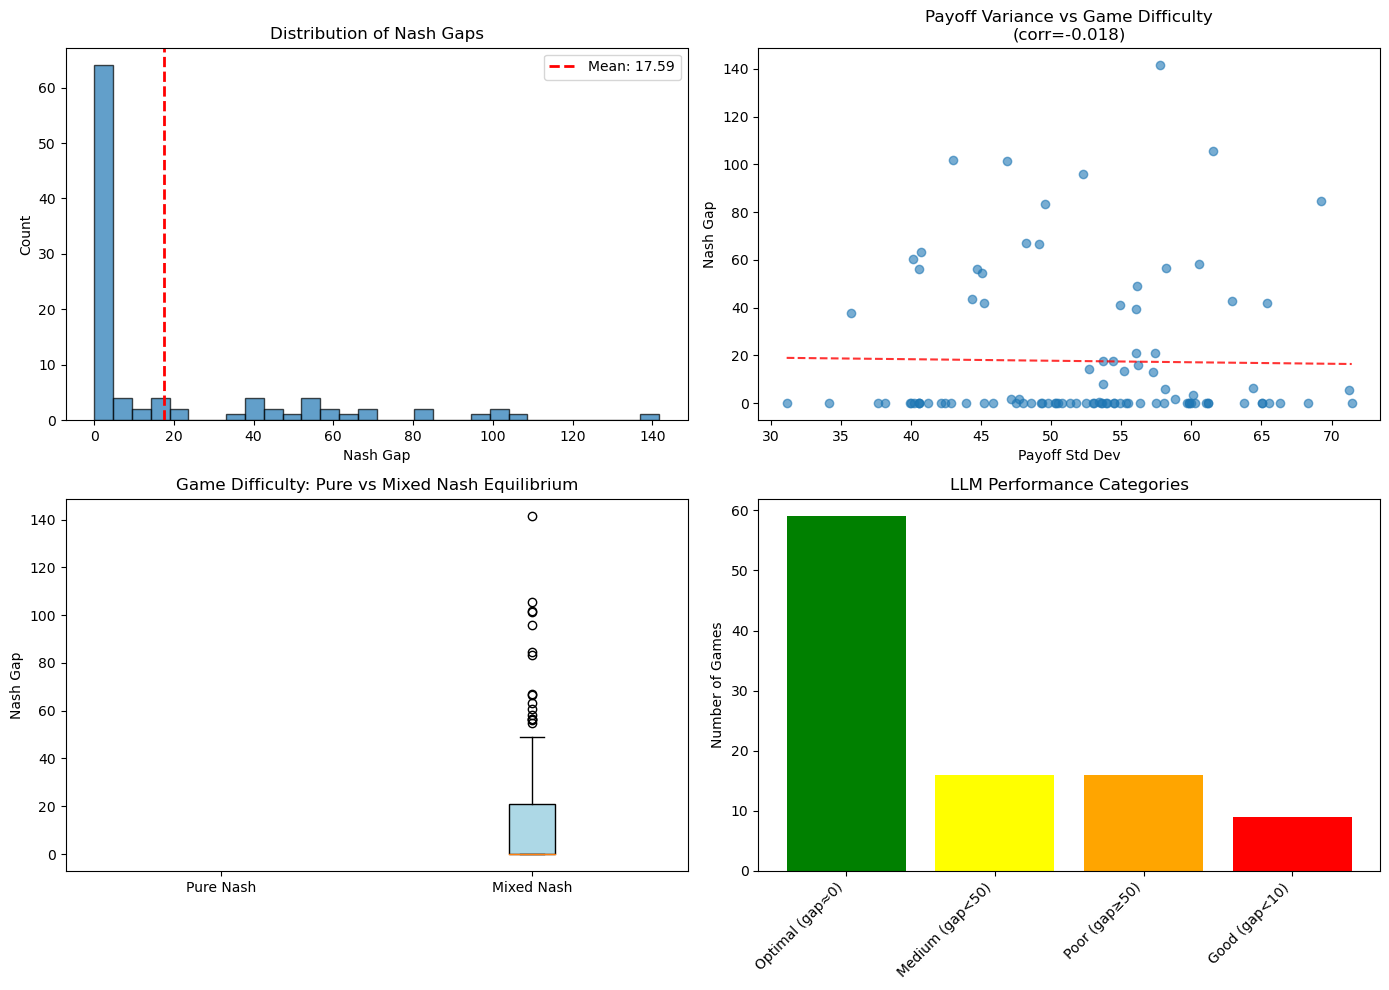

✓ Visualization saved to results/run_20260219_172049/performance_analysis.png


In [6]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Distribution of Nash gaps
ax = axes[0, 0]
ax.hist(merged_df['nash_gap'], bins=30, edgecolor='black', alpha=0.7)
ax.axvline(merged_df['nash_gap'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {merged_df["nash_gap"].mean():.2f}')
ax.set_xlabel('Nash Gap')
ax.set_ylabel('Count')
ax.set_title('Distribution of Nash Gaps')
ax.legend()

# Plot 2: Payoff std vs Nash gap
ax = axes[0, 1]
ax.scatter(merged_df['payoff_std'], merged_df['nash_gap'], alpha=0.6)
ax.set_xlabel('Payoff Std Dev')
ax.set_ylabel('Nash Gap')
ax.set_title(f'Payoff Variance vs Game Difficulty\n(corr={corr_payoff_std:.3f})')
z = np.polyfit(merged_df['payoff_std'], merged_df['nash_gap'], 1)
p = np.poly1d(z)
ax.plot(merged_df['payoff_std'].sort_values(), p(merged_df['payoff_std'].sort_values()), "r--", alpha=0.8)

# Plot 3: Pure vs Mixed Nash
ax = axes[1, 0]
data_to_plot = [pure_nash_subset, mixed_nash_subset]
bp = ax.boxplot(data_to_plot, labels=['Pure Nash', 'Mixed Nash'], patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
ax.set_ylabel('Nash Gap')
ax.set_title('Game Difficulty: Pure vs Mixed Nash Equilibrium')

# Plot 4: Performance categories
ax = axes[1, 1]
perf_counts = merged_df['performance_category'].value_counts()
colors = ['green', 'yellow', 'orange', 'red']
ax.bar(range(len(perf_counts)), perf_counts.values, color=colors[:len(perf_counts)])
ax.set_xticks(range(len(perf_counts)))
ax.set_xticklabels(perf_counts.index, rotation=45, ha='right')
ax.set_ylabel('Number of Games')
ax.set_title('LLM Performance Categories')

plt.tight_layout()
plt.savefig('../results/run_20260219_172049/performance_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Visualization saved to results/run_20260219_172049/performance_analysis.png")

## Section 5: Summary - Key Findings

In [7]:
print("""
╔════════════════════════════════════════════════════════════════════════════╗
║                         KEY FINDINGS                                       ║
╚════════════════════════════════════════════════════════════════════════════╝

🎯 WHERE DOES LLM EXCEL?
""")

optimal_pct = len(optimal_games) / len(merged_df) * 100
print(f"  ✓ {len(optimal_games)} games ({optimal_pct:.1f}%) played at Nash equilibrium")
print(f"  ✓ {(merged_df['nash_gap'] < 10).sum()} games ({(merged_df['nash_gap'] < 10).sum()/len(merged_df)*100:.1f}%) with gap < 10")

optimal_subset = merged_df[merged_df['nash_gap'] < 0.01]
if len(optimal_subset) > 0:
    print(f"\n  Features of games LLM plays optimally:")
    print(f"    - Avg payoff std dev: {optimal_subset['payoff_std'].mean():.2f}")
    print(f"    - Avg payoff range: {optimal_subset['payoff_range'].mean():.2f}")
    print(f"    - {(optimal_subset['is_pure_nash']).sum()/len(optimal_subset)*100:.1f}% have pure Nash equilibrium")

print(f"\n❌ WHERE DOES LLM STRUGGLE?")
print(f"  ✗ {len(hard_games)} games ({len(hard_games)/len(merged_df)*100:.1f}%) with gap > 50")
print(f"  ✗ {(merged_df['nash_gap'] > 100).sum()} very hard games with gap > 100")

hard_subset = merged_df[merged_df['nash_gap'] > 50]
if len(hard_subset) > 0:
    print(f"\n  Features of games LLM struggles with:")
    print(f"    - Avg payoff std dev: {hard_subset['payoff_std'].mean():.2f} (vs {merged_df['payoff_std'].mean():.2f} overall)")
    print(f"    - Avg payoff range: {hard_subset['payoff_range'].mean():.2f} (vs {merged_df['payoff_range'].mean():.2f} overall)")
    print(f"    - {(hard_subset['is_pure_nash']).sum()/len(hard_subset)*100:.1f}% have pure Nash equilibrium")

print(f"""
📊 CRITICAL GAME PROPERTIES:

  1. Payoff Variance (Std Dev)
     - Correlation with difficulty: {corr_payoff_std:.3f}
     - Interpretation: {'STRONG' if abs(corr_payoff_std) > 0.3 else 'WEAK'} predictor of game difficulty
     
  2. Pure vs Mixed Nash Equilibrium
     - Pure Nash avg gap: {pure_nash_subset.mean():.2f}
     - Mixed Nash avg gap: {mixed_nash_subset.mean():.2f}
     - Difference is {'SIGNIFICANT' if p_value < 0.05 else 'NOT significant'} (p={p_value:.4f})
     
  3. Game Difficulty Distribution
     - {(merged_df['nash_gap'] < 1).sum()} games nearly optimal
     - {(merged_df['nash_gap'] >= 1).sum()} games with measurable difficulty
     
📈 ACTIONABLE INSIGHTS:

  • Games with LOWER payoff variance are EASIER for LLM
  • {'Pure Nash equilibrium games appear harder' if pure_nash_subset.mean() > mixed_nash_subset.mean() else 'Mixed strategy games appear harder'}
  • LLM shows high variability in performance - some games are trivial, others very hard
  • Consider training on diverse game structures to improve robustness

═══════════════════════════════════════════════════════════════════════════════
""")

# Show correlation matrix
print("\nFull Correlation Matrix with Nash Gap:")
corr_matrix = merged_df[correlation_cols + ['is_pure_nash', 'has_dominant_row', 'nash_gap']].corr()
print(corr_matrix.round(3))


╔════════════════════════════════════════════════════════════════════════════╗
║                         KEY FINDINGS                                       ║
╚════════════════════════════════════════════════════════════════════════════╝

🎯 WHERE DOES LLM EXCEL?

  ✓ 59 games (59.0%) played at Nash equilibrium
  ✓ 68 games (68.0%) with gap < 10

  Features of games LLM plays optimally:
    - Avg payoff std dev: 51.73
    - Avg payoff range: 157.89
    - 0.0% have pure Nash equilibrium

❌ WHERE DOES LLM STRUGGLE?
  ✗ 16 games (16.0%) with gap > 50
  ✗ 4 very hard games with gap > 100

  Features of games LLM struggles with:
    - Avg payoff std dev: 50.47 (vs 52.38 overall)
    - Avg payoff range: 154.37 (vs 158.89 overall)
    - 0.0% have pure Nash equilibrium

📊 CRITICAL GAME PROPERTIES:

  1. Payoff Variance (Std Dev)
     - Correlation with difficulty: -0.018
     - Interpretation: WEAK predictor of game difficulty
     
  2. Pure vs Mixed Nash Equilibrium
     - Pure Nash avg gap: 